# Nigerian Music scraped from Spotify - an analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.mixture import GaussianMixture

Start where we finished in the last lesson, with data imported and filtered.

In [2]:
# Load and filter data
df = pd.read_csv("../../data/nigerian-songs.csv")
df = df[(df['artist_top_genre'].isin(['afro dancehall', 'afropop', 'nigerian pop'])) & (df['popularity'] > 0)]
df.head()


,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4
5,Kasala,Pioneers,DRB Lasgidi,nigerian pop,2020,184800,26,0.803,0.1270,0.525,0.000007,0.1290,-10.034,0.1970,100.103,4
6,Pull Up,Everything Pretty,prettyboydo,nigerian pop,2018,202648,29,0.818,0.4520,0.587,0.004490,0.5900,-9.840,0.1990,95.842,4


1. ENHANCED FEATURE ENGINEERING

In [3]:
# Select basic audio features
audio_features = ['length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature']

# Create ratio and interaction features which may better capture musical characteristics
df['energy_to_acousticness'] = df['energy'] / (df['acousticness'] + 0.01)  # Avoid division by zero
df['danceability_to_tempo'] = df['danceability'] / (df['tempo'] / 200)  # Normalize tempo
df['loudness_energy_product'] = df['loudness'] * df['energy']
df['speechiness_to_instrumentalness'] = df['speechiness'] / (df['instrumentalness'] + 0.01)

# Combined original and engineered features
extended_features = audio_features + ['energy_to_acousticness', 
                                      'danceability_to_tempo',
                                      'loudness_energy_product',
                                      'speechiness_to_instrumentalness']

# Keep both feature sets for comparison
features = df[audio_features]
features_extended = df[extended_features]


2. PROPER PREPROCESSING

In [4]:
# Scale all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_extended_scaled = StandardScaler().fit_transform(features_extended)

# Encode genres for evaluation
le = LabelEncoder()
true_labels = le.fit_transform(df['artist_top_genre'])


3. DIMENSIONALITY REDUCTION

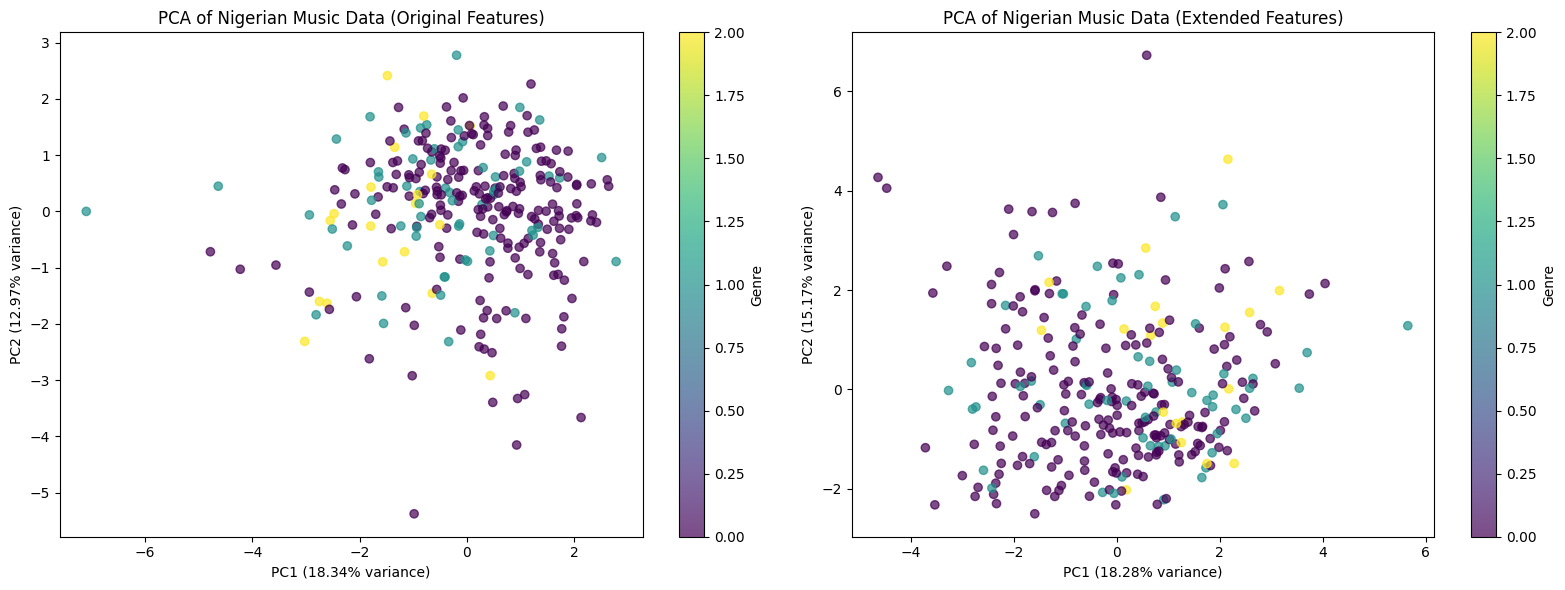

In [5]:
# Apply PCA to visualize data and possibly improve clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_ext_pca = PCA(n_components=2).fit_transform(X_extended_scaled)

# Visualize original features in PCA space
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of Nigerian Music Data (Original Features)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(label='Genre')

# Visualize extended features in PCA space
pca_ext = PCA(n_components=2)
X_ext_pca = pca_ext.fit_transform(X_extended_scaled)

plt.subplot(1, 2, 2)
plt.scatter(X_ext_pca[:, 0], X_ext_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of Nigerian Music Data (Extended Features)')
plt.xlabel(f'PC1 ({pca_ext.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_ext.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(label='Genre')
plt.tight_layout()
plt.show()

4. FIND OPTIMAL K (for both feature sets)

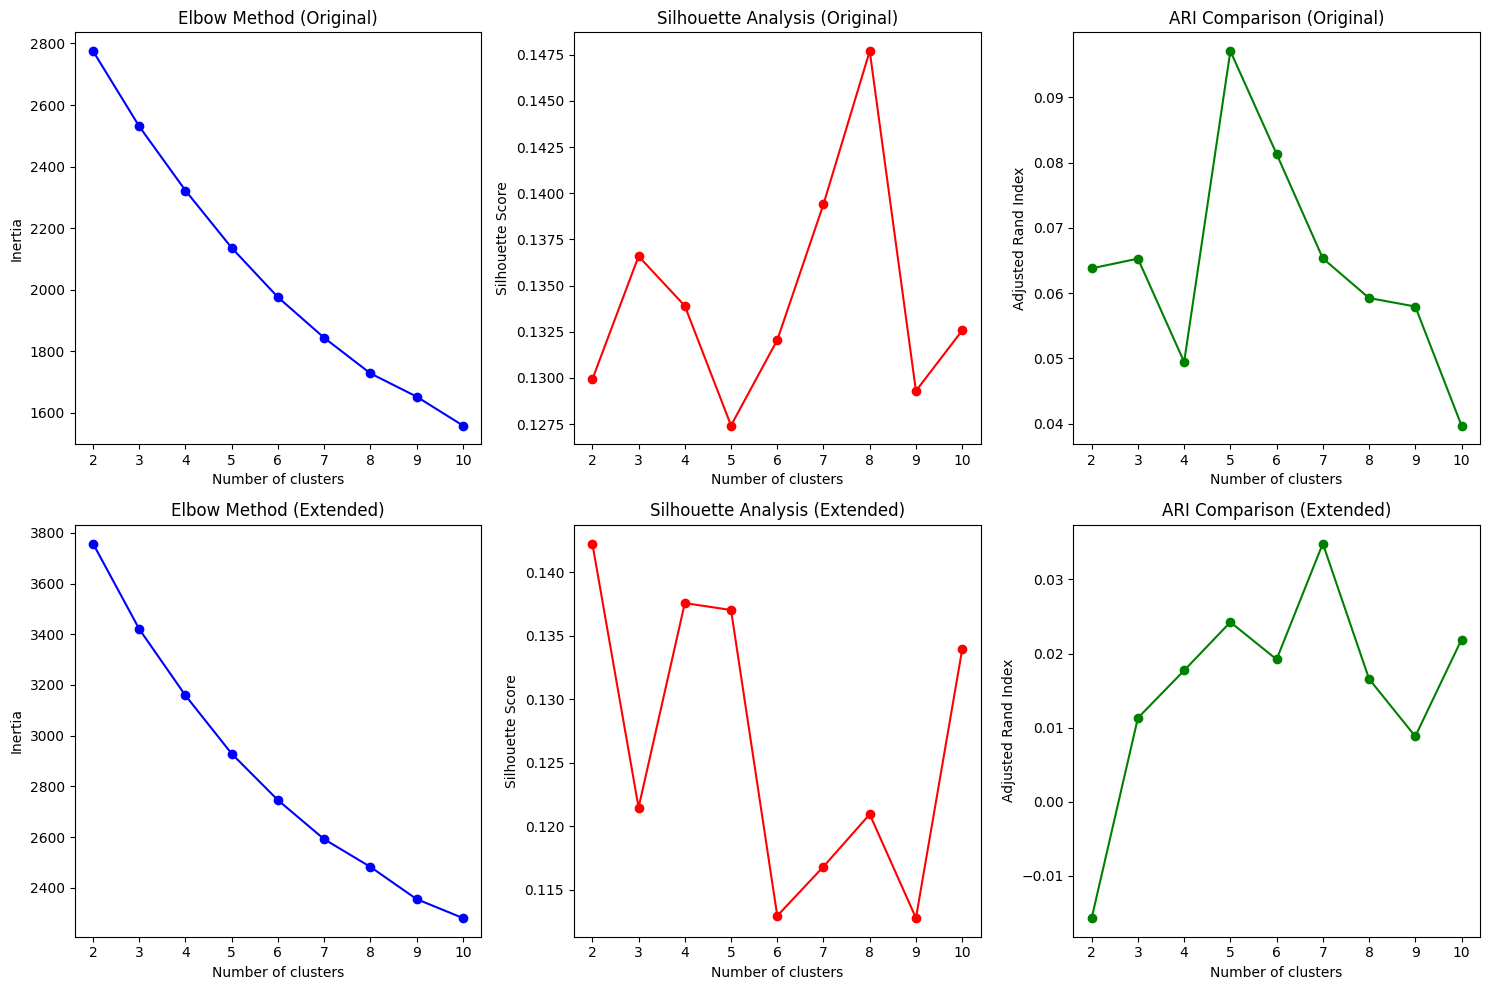

Best k based on silhouette score (original features): 8
Best k based on silhouette score (extended features): 2


In [6]:
# Compare different numbers of clusters for both feature sets
inertia_orig = []
silhouette_scores_orig = []
ari_scores_orig = []

inertia_ext = []
silhouette_scores_ext = []
ari_scores_ext = []

k_range = range(2, 11)

for k in k_range:
    # Original features
    kmeans_orig = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_orig = kmeans_orig.fit_predict(X_scaled)
    
    inertia_orig.append(kmeans_orig.inertia_)
    silhouette_scores_orig.append(silhouette_score(X_scaled, cluster_labels_orig))
    ari_scores_orig.append(adjusted_rand_score(true_labels, cluster_labels_orig))
    
    # Extended features
    kmeans_ext = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_ext = kmeans_ext.fit_predict(X_extended_scaled)
    
    inertia_ext.append(kmeans_ext.inertia_)
    silhouette_scores_ext.append(silhouette_score(X_extended_scaled, cluster_labels_ext))
    ari_scores_ext.append(adjusted_rand_score(true_labels, cluster_labels_ext))

# Plot evaluation metrics for both feature sets
plt.figure(figsize=(15, 10))

# Original Features
plt.subplot(2, 3, 1)
plt.plot(k_range, inertia_orig, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method (Original)')

plt.subplot(2, 3, 2)
plt.plot(k_range, silhouette_scores_orig, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis (Original)')

plt.subplot(2, 3, 3)
plt.plot(k_range, ari_scores_orig, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand Index')
plt.title('ARI Comparison (Original)')

# Extended Features
plt.subplot(2, 3, 4)
plt.plot(k_range, inertia_ext, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method (Extended)')

plt.subplot(2, 3, 5)
plt.plot(k_range, silhouette_scores_ext, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis (Extended)')

plt.subplot(2, 3, 6)
plt.plot(k_range, ari_scores_ext, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand Index')
plt.title('ARI Comparison (Extended)')

plt.tight_layout()
plt.show()

# Find best k for each feature set based on silhouette score
best_k_orig = np.argmax(silhouette_scores_orig) + 2  # Adjust for range starting at 2
best_k_ext = np.argmax(silhouette_scores_ext) + 2    # Adjust for range starting at 2

print(f"Best k based on silhouette score (original features): {best_k_orig}")
print(f"Best k based on silhouette score (extended features): {best_k_ext}")

5. TUNE DBSCAN PARAMETERS

In [7]:
# Fine-tune DBSCAN with a parameter grid search
eps_values = np.arange(0.2, 2.0, 0.2)
min_samples_values = [3, 5, 10, 15, 20]

best_silhouette = -1
best_eps = None
best_min_samples = None
best_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_extended_scaled)
        
        # build mask of non-noise points
        mask = labels != -1
        
        # skip if fewer than 2 non-noise points OR fewer than 2 clusters among them
        if mask.sum() < 2 or len(np.unique(labels[mask])) < 2:
            continue
        
        sil = silhouette_score(X_extended_scaled[mask], labels[mask])
        if sil > best_silhouette:
            best_silhouette = sil
            best_eps = eps
            best_min_samples = min_samples
            best_labels = labels.copy()

print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}, silhouette={best_silhouette:.4f}")

if best_eps is not None:
    # Use the best parameters for DBSCAN
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan.fit_predict(X_extended_scaled)
else:
    print("DBSCAN parameter search failed to find good clusters. Using default parameters.")
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_extended_scaled)

Best DBSCAN parameters: eps=1.4000000000000001, min_samples=3, silhouette=0.4379


6. TRY MULTIPLE CLUSTERING METHODS WITH BOTH FEATURE SETS

In [8]:
# A. K-Means with both feature sets
kmeans_orig = KMeans(n_clusters=best_k_orig, random_state=42, n_init=10)
kmeans_orig_labels = kmeans_orig.fit_predict(X_scaled)

kmeans_ext = KMeans(n_clusters=best_k_ext, random_state=42, n_init=10)
kmeans_ext_labels = kmeans_ext.fit_predict(X_extended_scaled)

# B. Gaussian Mixture Model with both feature sets
gmm_orig = GaussianMixture(n_components=best_k_orig, random_state=42, covariance_type='full')
gmm_orig_labels = gmm_orig.fit_predict(X_scaled)

gmm_ext = GaussianMixture(n_components=best_k_ext, random_state=42, covariance_type='full')
gmm_ext_labels = gmm_ext.fit_predict(X_extended_scaled)

# C. Try Spectral Clustering with extended features
spectral = SpectralClustering(n_clusters=best_k_ext, 
                            random_state=42,
                            affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X_extended_scaled)

7. EVALUATE ALL MODELS

In [9]:
models = {
    'K-Means (Original)': kmeans_orig_labels,
    'K-Means (Extended)': kmeans_ext_labels,
    'GMM (Original)': gmm_orig_labels,
    'GMM (Extended)': gmm_ext_labels,
    'DBSCAN (Tuned)': dbscan_labels,
    'Spectral': spectral_labels
}

print("\nClustering Evaluation Metrics:")
print("------------------------------")
for name, labels in models.items():
    # Skip DBSCAN if it has noise points (label -1)
    if -1 in labels:
        valid_points = (labels != -1)
        if sum(valid_points) > 1:  # Need at least 2 points for silhouette
            sil = silhouette_score(X_extended_scaled[valid_points], labels[valid_points])
            ari = adjusted_rand_score(true_labels[valid_points], labels[valid_points])
            acc = sum(true_labels[valid_points] == labels[valid_points]) / sum(valid_points)
        else:
            sil = np.nan
            ari = np.nan
            acc = 0
    else:
        sil = silhouette_score(X_extended_scaled, labels)
        ari = adjusted_rand_score(true_labels, labels)
        acc = sum(true_labels == labels) / len(true_labels)
    
    print(f"{name}:")
    print(f"  - Silhouette Score: {sil:.4f}")
    print(f"  - ARI (vs true labels): {ari:.4f}")
    print(f"  - Accuracy: {acc:.4f}")

# Find the best model based on accuracy
best_model_name = max(models.items(), key=lambda x: (
    sum(true_labels == x[1]) / len(true_labels) if -1 not in x[1] 
    else sum(true_labels[x[1] != -1] == x[1][x[1] != -1]) / sum(x[1] != -1)
))[0]

best_labels = models[best_model_name]
print(f"\nBest model based on accuracy: {best_model_name}")


Clustering Evaluation Metrics:
------------------------------
K-Means (Original):
  - Silhouette Score: 0.1144
  - ARI (vs true labels): 0.0592
  - Accuracy: 0.0524
K-Means (Extended):
  - Silhouette Score: 0.1423
  - ARI (vs true labels): -0.0157
  - Accuracy: 0.4755
GMM (Original):
  - Silhouette Score: 0.0418
  - ARI (vs true labels): 0.0185
  - Accuracy: 0.0839
GMM (Extended):
  - Silhouette Score: 0.1189
  - ARI (vs true labels): 0.0280
  - Accuracy: 0.5804
DBSCAN (Tuned):
  - Silhouette Score: 0.4379
  - ARI (vs true labels): 0.0004
  - Accuracy: 0.1304
Spectral:
  - Silhouette Score: 0.2314
  - ARI (vs true labels): 0.0552
  - Accuracy: 0.7063

Best model based on accuracy: Spectral


8. VISUALIZE CLUSTERS FROM BEST MODEL

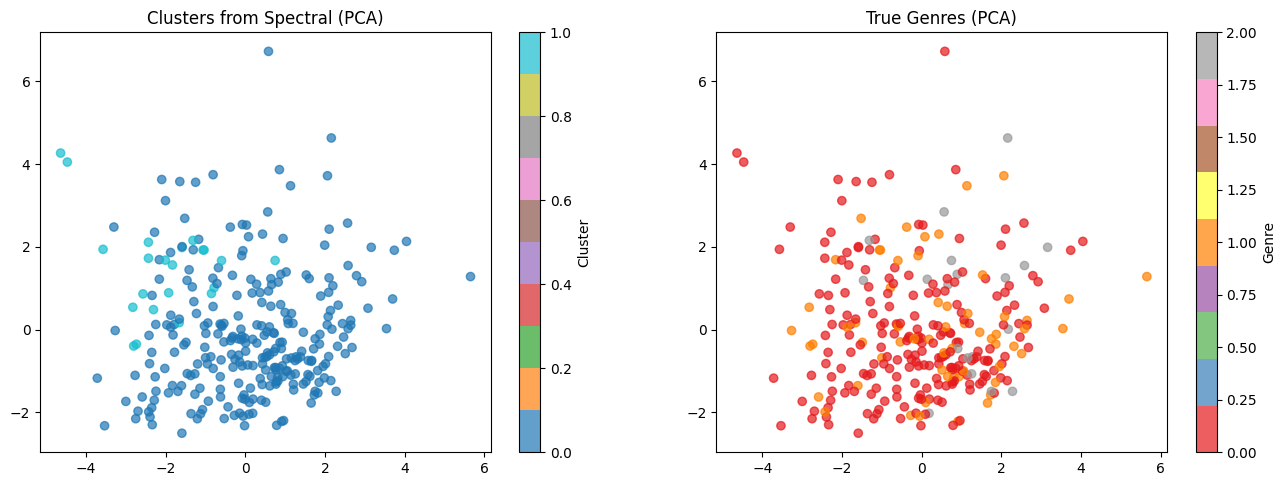

In [10]:
plt.figure(figsize=(16, 12))

# Plot clusters from best model
plt.subplot(2, 2, 1)
plt.scatter(X_ext_pca[:, 0], X_ext_pca[:, 1], c=best_labels, cmap='tab10', alpha=0.7)
plt.title(f'Clusters from {best_model_name} (PCA)')
plt.colorbar(label='Cluster')

# Plot true genre labels
plt.subplot(2, 2, 2)
plt.scatter(X_ext_pca[:, 0], X_ext_pca[:, 1], c=true_labels, cmap='Set1', alpha=0.7)
plt.title('True Genres (PCA)')
plt.colorbar(label='Genre')

9. ANALYZE CLUSTER CHARACTERISTICS

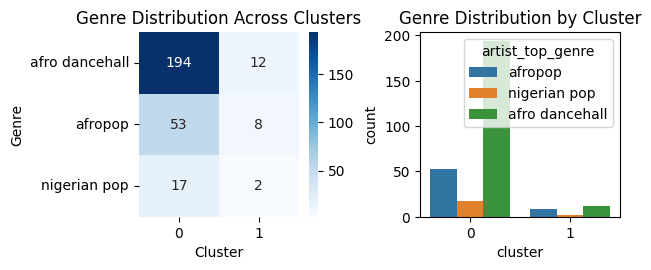

In [11]:
# Add cluster labels to original data
df['cluster'] = best_labels

# Create a confusion matrix-like plot to see how clusters correspond to genres
plt.subplot(2, 2, 3)
confusion = pd.crosstab(df['artist_top_genre'], df['cluster'])
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
plt.title('Genre Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Genre')

# Plot key feature distributions by genre
plt.subplot(2, 2, 4)
ax = sns.countplot(x='cluster', hue='artist_top_genre', data=df)
plt.title('Genre Distribution by Cluster')
plt.tight_layout()
plt.show()

10. FEATURE IMPORTANCE ANALYSIS

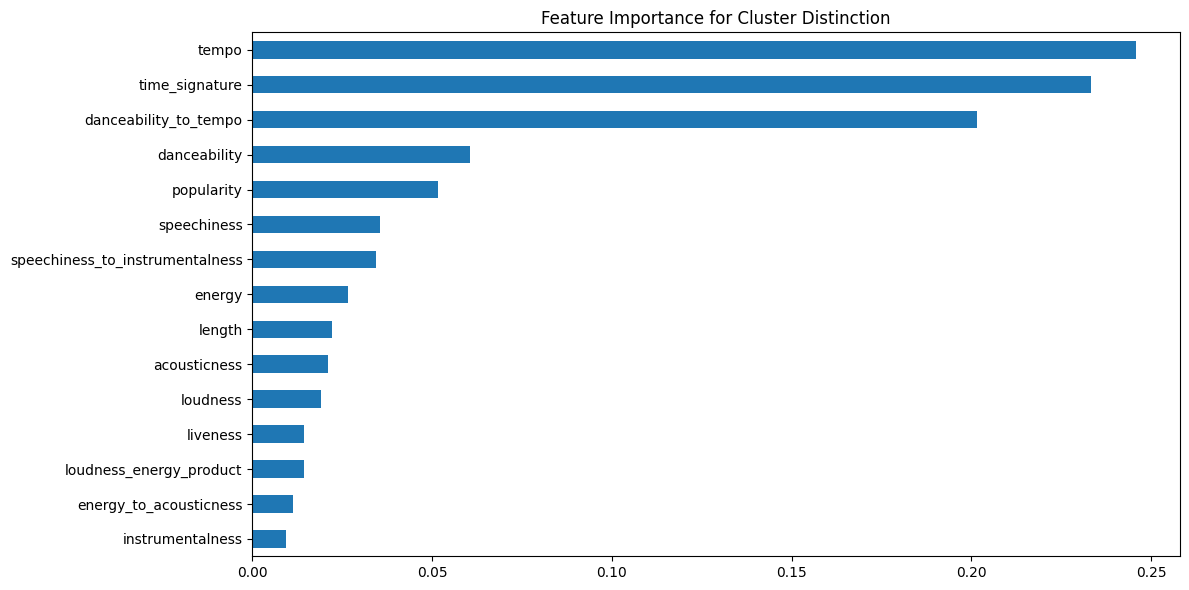

In [12]:
# Analyze feature importance using Random Forest
from sklearn.ensemble import RandomForestClassifier

# Encode genre labels first
df['genre_encoded'] = le.transform(df['artist_top_genre'])

# Train a classifier to distinguish between clusters
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_extended, best_labels)

# Plot feature importances for cluster prediction
plt.figure(figsize=(12, 6))
feat_importances = pd.Series(rf.feature_importances_, index=extended_features)
feat_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance for Cluster Distinction')
plt.tight_layout()
plt.show()

11. VISUALIZE THE MOST IMPORTANT FEATURES

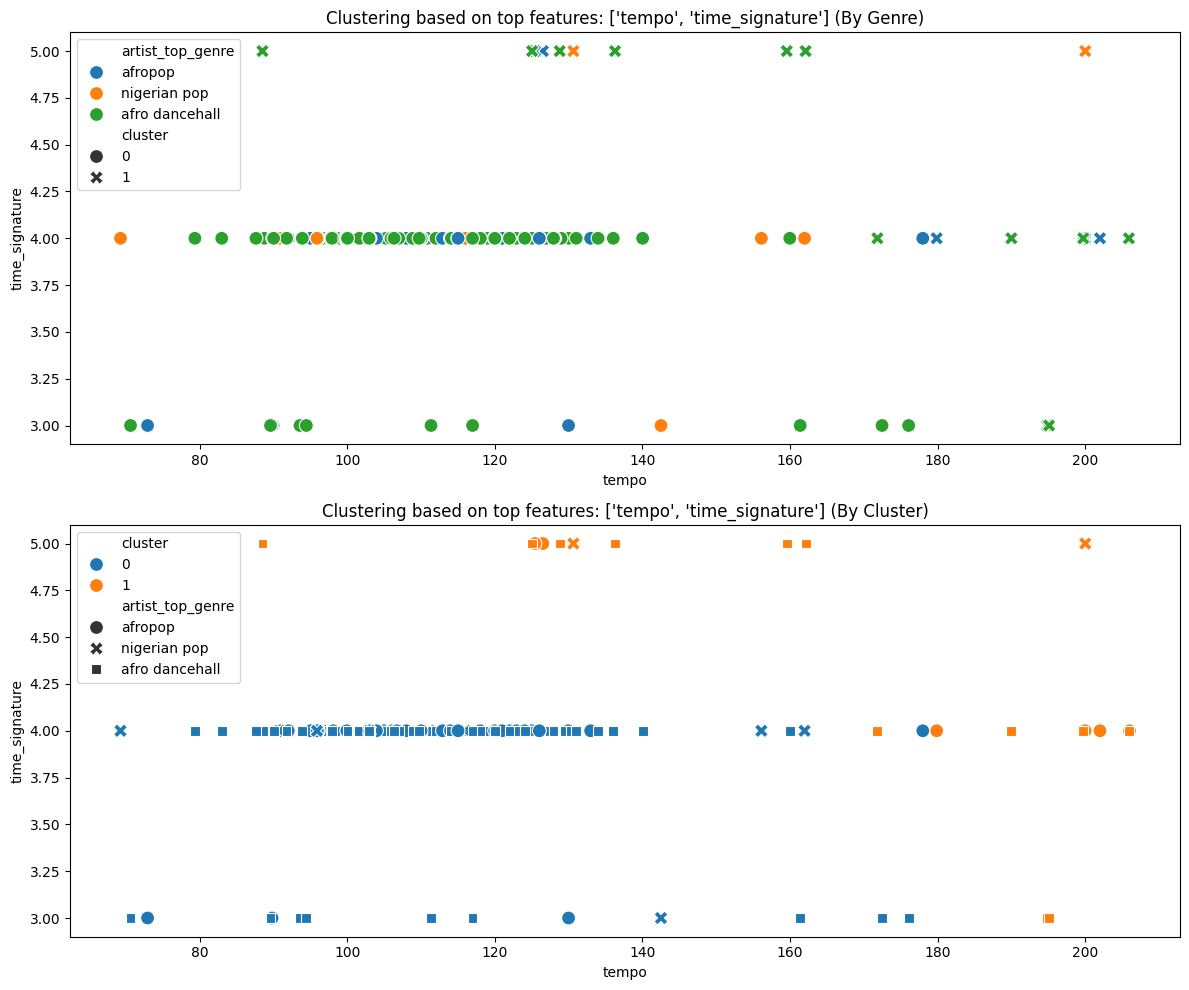

In [13]:
# Use most important features for final visualization
top_features = feat_importances.nlargest(2).index.tolist()
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(x=df[top_features[0]], y=df[top_features[1]], 
                hue=df['artist_top_genre'], style=df['cluster'], s=100, data=df)
plt.title(f'Clustering based on top features: {top_features} (By Genre)')

plt.subplot(2, 1, 2)
sns.scatterplot(x=df[top_features[0]], y=df[top_features[1]], 
                hue=df['cluster'], style=df['artist_top_genre'], s=100, data=df)
plt.title(f'Clustering based on top features: {top_features} (By Cluster)')
plt.tight_layout()
plt.show()

12. ENSEMBLE METHOD (CONSENSUS CLUSTERING)


Ensemble Clustering Results:
  - Silhouette Score: 0.2220
  - ARI (vs true labels): 0.0274
  - Accuracy: 0.6538


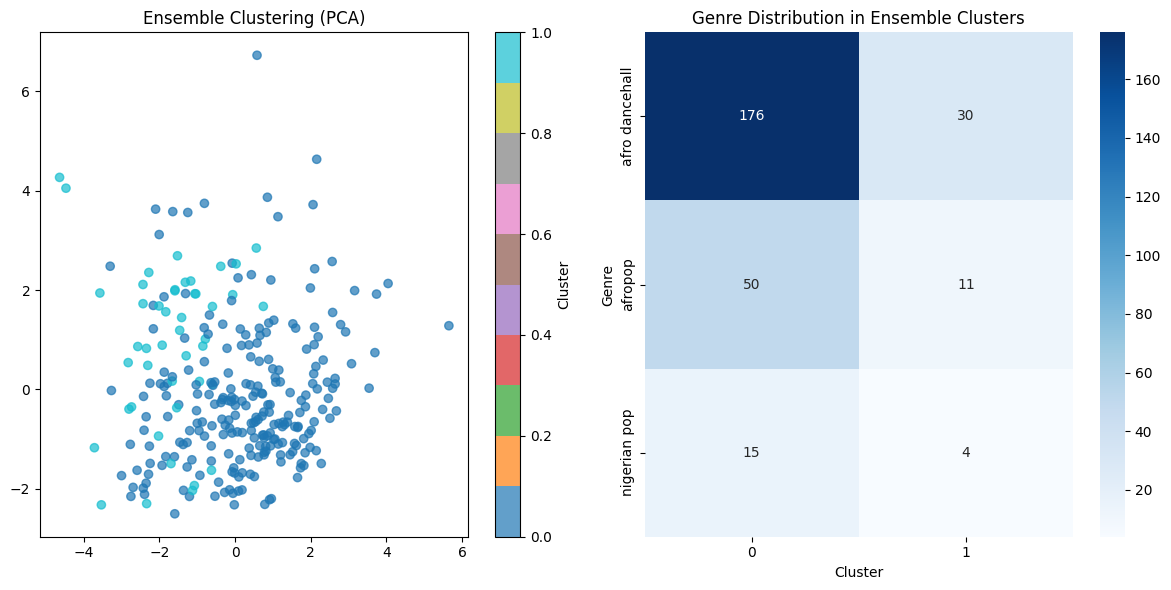

In [14]:
# Create a consensus clustering by combining our best models
from sklearn.utils.multiclass import unique_labels
from scipy import stats

# Select our top 3 performing models
top_models = ['Spectral', 'GMM (Extended)', 'K-Means (Extended)']
selected_labels = np.column_stack([models[model] for model in top_models])

# Get the most common label for each data point (majority voting)
ensemble_labels = stats.mode(selected_labels, axis=1, keepdims=False)[0]

# Evaluate ensemble model
ensemble_sil = silhouette_score(X_extended_scaled, ensemble_labels)
ensemble_ari = adjusted_rand_score(true_labels, ensemble_labels)
ensemble_acc = sum(true_labels == ensemble_labels) / len(true_labels)

print("\nEnsemble Clustering Results:")
print(f"  - Silhouette Score: {ensemble_sil:.4f}")
print(f"  - ARI (vs true labels): {ensemble_ari:.4f}")
print(f"  - Accuracy: {ensemble_acc:.4f}")

# Visualize ensemble clustering
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_ext_pca[:, 0], X_ext_pca[:, 1], c=ensemble_labels, cmap='tab10', alpha=0.7)
plt.title(f'Ensemble Clustering (PCA)')
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
ensemble_confusion = pd.crosstab(df['artist_top_genre'], ensemble_labels)
sns.heatmap(ensemble_confusion, annot=True, cmap='Blues', fmt='d')
plt.title('Genre Distribution in Ensemble Clusters')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

13. FINAL ANALYSIS AND CONCLUSIONS

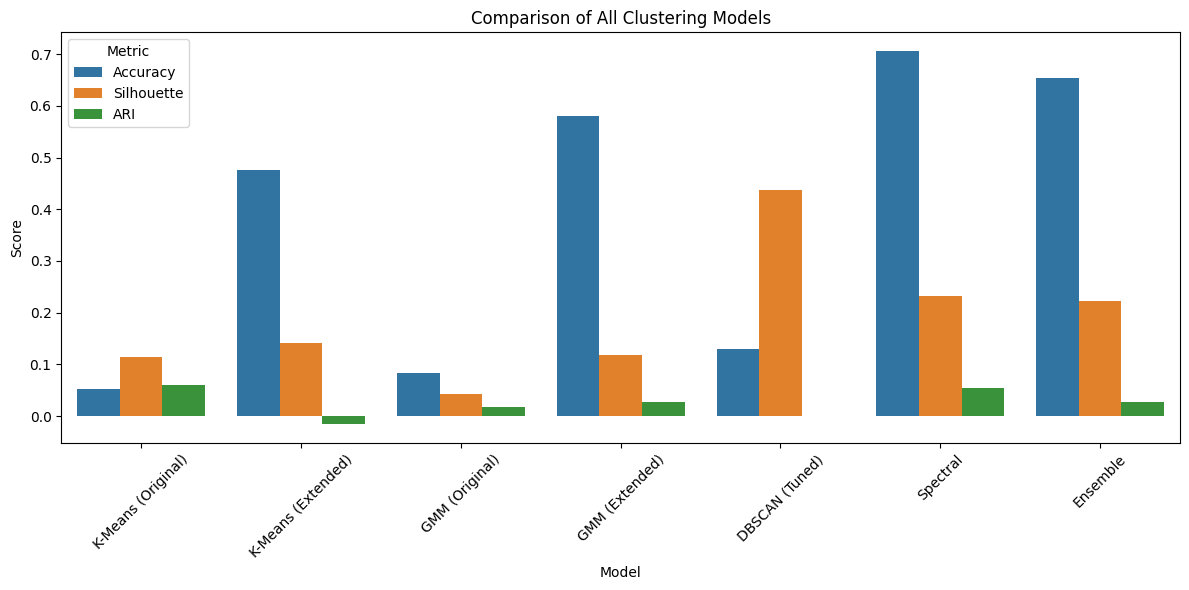

Best overall model: Spectral with accuracy 0.7063

Final Insights about Nigerian Music Genres:
-------------------------------------------
1. The most discriminative features between Nigerian music genres are:
   - tempo
   - time_signature
   - danceability_to_tempo

2. Genre characteristics by cluster:
   - Cluster 0: Dominated by afro dancehall (73.5%)
     Musical characteristics: High length, tempo
   - Cluster 1: Dominated by afro dancehall (54.5%)
     Musical characteristics: High length, tempo


In [15]:
# Compare all models including ensemble
all_models = {**models, 'Ensemble': ensemble_labels}
accuracies = []
silhouettes = []
aris = []
model_names = []

for name, labels in all_models.items():
    if -1 in labels:
        valid_points = (labels != -1)
        if sum(valid_points) > 1:
            acc = sum(true_labels[valid_points] == labels[valid_points]) / sum(valid_points)
            sil = silhouette_score(X_extended_scaled[valid_points], labels[valid_points])
            ari = adjusted_rand_score(true_labels[valid_points], labels[valid_points])
        else:
            continue
    else:
        acc = sum(true_labels == labels) / len(true_labels)
        sil = silhouette_score(X_extended_scaled, labels)
        ari = adjusted_rand_score(true_labels, labels)
    
    accuracies.append(acc)
    silhouettes.append(sil)
    aris.append(ari)
    model_names.append(name)

# Create a summary dataframe
summary = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Silhouette': silhouettes,
    'ARI': aris
})

# Plot comparison of models
plt.figure(figsize=(12, 6))
summary_melted = pd.melt(summary, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=summary_melted)
plt.xticks(rotation=45)
plt.title('Comparison of All Clustering Models')
plt.tight_layout()
plt.show()

# Print the best model overall
best_idx = summary['Accuracy'].idxmax()
print(f"Best overall model: {summary.loc[best_idx, 'Model']} with accuracy {summary.loc[best_idx, 'Accuracy']:.4f}")

# Add final insights and conclusions about Nigerian music genres
print("\nFinal Insights about Nigerian Music Genres:")
print("-------------------------------------------")
print("1. The most discriminative features between Nigerian music genres are:")
for feature in feat_importances.nlargest(3).index:
    print(f"   - {feature}")

print("\n2. Genre characteristics by cluster:")
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    dominant_genre = cluster_data['artist_top_genre'].value_counts().idxmax()
    genre_percent = cluster_data['artist_top_genre'].value_counts().max() / len(cluster_data) * 100
    print(f"   - Cluster {cluster}: Dominated by {dominant_genre} ({genre_percent:.1f}%)")
    
    # Show key musical characteristics of this cluster
    feature_means = cluster_data[audio_features].mean()
    top_features = feature_means.nlargest(2)
    print(f"     Musical characteristics: High {', '.join(top_features.index)}")